# Selecting Values for Simulation Parameters

When running a simulation, there are lots of parameters to choose values for.  In the tutorials so far, we have mostly used the default values selected by OpenMM-Setup.  These values are chosen to be appropriate for most biomolecular simulations.  Usually they will give good results, but not always.  In this tutorial we will discuss the significance of some of them, and how to choose values for your own simulations.

## Speed vs. Accuracy

Most parameters involve some kind of tradeoff between speed and accuracy.  You can make the simulation run faster, or you can make the results more accurate.  The best value depends on your particular needs: what quantities you want to calculate, how accurate they need to be, how much computer time you have.

Accuracy can mean two different things.  First there is **physical accuracy**.  How well does your mathematical model match the physical system you want to study?  Depending on your needs you might select a coarse grained model, an all atom force field, or a high level quantum chemistry method.  Even within the category of all atom force fields there are many choices.  Do you need a polarizable force field, or is a non-polarizable one accurate enough?  Will you use implicit or explicit solvent?  These questions are mostly outside the scope of this tutorial.

Second there is **numerical accuracy**.  How accurately are you computing the forces?  How accurately are you integrating the equations of motion?  These are the questions we will focus on.

## Integrator Step Size

The very most important parameter controlling integration accuracy is the step size.  The larger each step is, the fewer steps you need to cover the same amount of simulation time, but the less accurate your trajectory is.  If the step size is just a little bit too large, your simulation may seem to run normally, but your results will be inaccurate.  If it is much too large, the simulation will probably blow up and the particles will fly off to infinity.

The step size is important in itself, but it also interacts with many other settings.  You can't choose it in isolation.  It depends on what other choices you make.

Generally speaking, the integration step size is determined by the fastest motion present in the system.  Here is a good rule of thumb: whatever the highest frequency motion in the system is, the step size should be about 1/10 to 1/5 of its period.

If you remove the fastest motions, you can make the step size larger without increasing integration error.  In most biomolecular systems, the fastest motions are the bond length oscillations for bonds involving hydrogen.  The forces to maintain the lengths of covalent bonds are among the strongest in the system, and hydrogen is much lighter than other elements.  That is why `constraints=HBonds` is a common choice, and the default in OpenMM-Setup.  Constraining the length of those bonds, you can often double the step size.

You can increase the step size more if you constrain more degrees of freedom: `constraints=AllBonds` (constrain all bond lengths) or `constraints=HAngles` (constrain all bond lengths, plus angles involving hydrogen), but this should be done with care.  The more constraints you add, the more rigid the model becomes.  This is a case of trading physical accuracy for speed.  Most often people stop at `HBonds`, which gives much of the benefit while only slightly affecting rigidity.

Another option is to slow down the fastest motions, for example by increasing the masses of hydrogens.  But you don't want to *just* increase the hydrogen mass; that would make the molecule heavier, causing all motions to slow down.  Instead you repartition the mass, increasing the masses of hydrogens while decreasing the masses of the atoms they are bonded to so the total mass is unchanged.  A small amount of hydrogen mass repartitioning can be an effective way to increase the time step while having minimal effect on dynamics.  The default value in OpenMM-Setup is `hydrogenMass=1.5*amu`, which is generally a good choice.

For an analysis of the typical time scales found in biomolecular simulations, see https://doi.org/10.1002/(SICI)1096-987X(199906)20:8%3C786::AID-JCC5%3E3.0.CO;2-B.

## Constant Temperature or Constant Energy?

Since our goal is to use the largest possible step size that produces acceptable accuracy, we need to answer an obvious question: how accurate does the simulation need to be?  The answer depends critically on whether you are simulating a system at constant temperature or constant energy.

In a constant energy simulation, you expect the energy to truly be constant.  Any error in integration will cause it to drift with time.  Even if the drift is slow, eventually it will add up to a large change from the initial energy, and you will no longer be simulating what you intended to simulate.

In a constant temperature simulation, energy drift over long periods is impossible.  The system constantly exchanges energy with a heat bath, which forces it to maintain the correct energy distribution.  Every thermostat has a characteristic time scale $\tau$ over which it exchanges energy between the system and heat bath.  For a Langevin thermostat, the time scale is given by $\tau = 1/\gamma$, where $\gamma$ is the friction coefficient.  The default setting in OpenMM-Setup is $\tau$ = 1 ps.

This leads to the following conclusions.

- In a constant temperature simulation, energy drift must be negligible over the time constant of the thermostat.
- In a constant energy simulation, energy drift must be negligible over the entire length of the simulation.

The latter tends to be many orders of magnitude larger than the former, which means that constant energy simulations usually need a much smaller time step than constant temperature ones.  The default step size in OpenMM-Setup is 4 fs, which works well for constant temperature with `HBonds` constraints and hydrogen mass repartitioning.  In constant energy simulations, the step size is usually only 1 to 2 fs, sometimes even less.

## Other Settings for Integration Accuracy

If your simulation involves constraints, you need to consider how accurately the constraints will be enforced.  Some constraints (for rigid water molecules) are computed exactly to machine precision.  Others are computed approximately with an iterative algorithm.  The more accurate they need to be, the more iterations are required, causing the simulation to slow down.

The default setting in OpenMM-Setup is `constraintTolerance=0.000001`.  This value works well in most situations, and there is rarely a need to change it.  If you are running a constant temperature simulation, and you want to make it as fast as possible, it usually is acceptable to increase the tolerance to `0.00001`.  This has a small speed benefit, and the accuracy is still usually acceptable.  Do not do this in constant energy simulations, though, because the energy drift will be unacceptable.

When running a simulation on a GPU with the CUDA, OpenCL, or HIP platform, an important setting is the numerical precision.  Many GPUs are very slow at double precision math.  We therefore want to use single precision whenever possible.

The GPU platforms have a `'Precision'` property for selecting between three modes.  The default in OpenMM-Setup is `'single'`, which does all calculations in single precision.  It is the fastest choice, and the accuracy is usually good enough for constant temperature simulations.

For constant energy simulations it is better to use `'mixed'` mode, which computes forces in single precision but performs integration in double precision.  This significantly reduces energy drift without slowing down the simulation too much.  You can specify the precision mode with the `platformProperties` argument when creating a Simulation:

```python
simulation = Simulation(topology, system, integrator, platform, {'Precision':'mixed'})
```

There also is a `'double'` mode, which performs all calculations in double precision.  This is only needed in unusual situations, and can be very slow on some GPUs.

## Measuring Energy Drift

Given how many things influence energy drift, it is important to have a way to measure it.  This turns out to be a little more complicated than you might expect.  Here we will demonstrate how to do it.  Let's begin by importing the packages we will use.  We also load a PDB file with the molecule we will simulate (a deca-alanine peptide) and the force field we will use to model it, and create a System with constraints and hydrogen mass repartitioning.

In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *
import matplotlib.pyplot as plot

pdb = PDBFile('deca-ala.pdb')
forcefield = ForceField('amber19-all.xml')
system = forcefield.createSystem(pdb.topology, constraints=HBonds, hydrogenMass=1.5*amu)

To measure energy drift, we first need a way to compute energy.  Can't we just call `getPotentialEnergy()` and `getKineticEnergy()` on a State object, then add them together?  Yes you can, but the result will not be very accurate.  While the Verlet integration algorithm involves both positions and velocities, they are not on an equal footing with each other.  The positions are accurate to third order in the step size, the intrinsic accuracy of the algorithm, while the velocities are only accurate to first order.  In fact, it is best not to think of the "velocities" as really being velocities at all.  They are an internal parameter of the algorithm that happens to be a low order approximation to the velocities.

A much better way to compute kinetic energy is to compute a higher order velocity from the positions at multiple times.  A [five point stencil](https://en.wikipedia.org/wiki/Five-point_stencil) gives velocities accurate to third order in the step size, the same as the positions.  The following function takes five steps and computes a high accuracy energy at the middle step.

In [2]:
def computeEnergy(simulation):
    states = []
    for _ in range(5):
        states.append(simulation.context.getState(positions=True, energy=True))
        simulation.step(1)
    positions = [state.getPositions(asNumpy=True) for state in states]
    dt = simulation.integrator.getStepSize()
    velocities = (-positions[4] + 8*positions[3] - 8*positions[1] + positions[0]) / (12*dt)
    kinetic = sum([0.5*simulation.system.getParticleMass(i)*norm(velocities[i])**2 for i in range(system.getNumParticles())])
    potential = states[2].getPotentialEnergy()
    return kinetic+potential

Now we can measure energy drift.  The following function runs a simulation for 100 ps, recording the total energy every 1 ps (keeping in mind that the call to `computeEnergy()` will take five steps).

In [12]:
def measureDrift(simulation):
    simulation.context.setPositions(pdb.positions)
    simulation.context.setVelocitiesToTemperature(300*kelvin)
    e0 = computeEnergy(simulation)
    steps = 1*picosecond/simulation.integrator.getStepSize() - 5
    energy = []
    for _ in range(100):
        simulation.integrator.step(steps)
        energy.append((computeEnergy(simulation)-e0).value_in_unit(kilojoules_per_mole))
    return energy

Let's try simulating our peptide and see how the drift varies with step size.

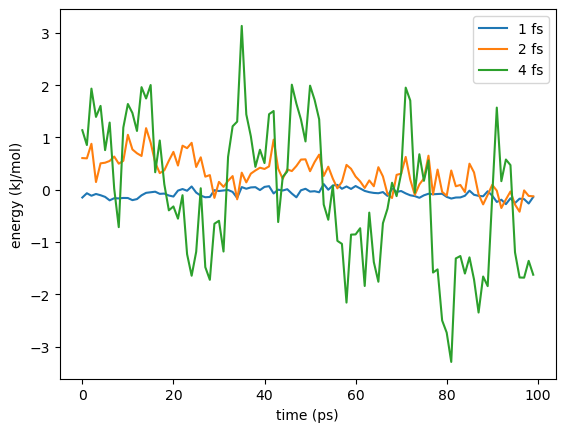

In [11]:
for dt in (1, 2, 4):
    integrator = VerletIntegrator(dt*femtosecond)
    simulation = Simulation(pdb.topology, system, integrator, Platform.getPlatform('Reference'))
    energy = measureDrift(simulation)
    plot.plot(energy, label=f'{dt} fs')
plot.xlabel('time (ps)')
plot.ylabel('energy (kJ/mol)')
plot.legend()
plot.show()

With a 1 fs time step, there is very little drift over the simulation.  With a 2 fs time step there is more, and much more with 4 fs.

In addition to the increased drift, the random fluctuations in the energy grow with the step size, but don't pay much attention to that.  Remember, we are calculating the velocities with a finite difference approximation whose error scales with $dt^4$.  If you double the step size, the error in the velocities is multiplied by 16, but that has nothing to do with the accuracy of the simulation.  Just focus on the long term drift.

## How Accurate Does Energy Drift Need to Be?

Now that we can measure the energy drift we need to select simulation parameters based on it.  There is no universal way to do that.  It depends on your specific application: the system you are simulating, your simulation protocol, and the quantities you want to calculate.

Look at the graph comparing different step sizes.  Even at the largest step size, the drift is only about 1 kJ/mol over the simulation.  In most applications, an error that small is acceptable.  Then again, most simulations are longer than 100 ps.  In a longer simulation the error would soon grow to an unacceptable level.  Also, we are only simulating a small peptide.  With a larger system, the drift would probably be larger.  You need to understand what level of accuracy is necessary to compute the quantities you care about from your simulations.

Of course, this is a constant energy simulation.  If your production simulations will use constant temperature, you only care about the drift over the time constant of the thermostat, not over the whole simulation.

Beware of interpreting energy drift in overly simplistic ways.  For example, people will sometimes fit a straight line to the graph of energy vs. time and report only the slope of the line—even though energy drift often is not linear in time, making a linear fit meaningless!  They also sometimes divide the result by temperature and system size, reporting the energy drift per time per Kelvin per degree of freedom.  Energy drift is not generally linear either in temperature or system size, making this an entirely meaningless quantity.  For more information about these issues see https://www.biorxiv.org/content/10.1101/083055v1.

## Computing Nonbonded Interactions

Another very important set of options are the ones related to nonbonded interactions (Coulomb and Lennard-Jones, and possibly implicit solvent).  The exact choices available depend on whether your system is periodic or non-periodic.

For a non-periodic system, the main choice is whether to apply a cutoff.  The most accurate method is to compute all interactions regardless of distance (`nonbondedMethod=NoCutoff`), but this can be very slow for large systems.  Applying a cutoff with `nonbondedMethod=CutoffNonPeriodic` is faster but less accurate.

For simulations with implicit solvent, a 2 nm cutoff usually produces acceptable accuracy.  Dielectric screening from the implicit solvent reduces the strength of long-range Coulomb interactions.  The error from ignoring them is usually not too great.  For vacuum simulations, cutoffs are more problematic.  Unless you are sure you know what you are doing, it is best to avoid cutoffs in vacuum simulations.

When simulating periodic systems there are three common options for the nonbonded method: `CutoffPeriodic`, `PME`, and `LJPME`.  All of them include a setting for the cutoff distance, but the exact meaning of that setting is different for each method.

- **CutoffPeriodic**: When using this method, all interactions beyond the cutoff distance are ignored.  The energy is smoothly reduced to zero at the cutoff with the reaction field method.  This is a physical approximation based on two assumptions.  1) Everything beyond the cutoff distance is filled with water.  2) Bulk water can be modeled as a uniform dielectric.  For small globular proteins in water, this approximation can be extremely accurate.  A cutoff of 1.2 nm tends to give good results.  For larger solutes, and especially for systems that do not primarily consist of solvent, it is better to use one of the other methods.
- **PME**: This option uses Particle Mesh Ewald to compute the full set of long-range Coulomb interactions in a periodic system.  The cutoff distance determines how work is divided between the direct space and reciprocal space parts of the calculation.  That means it does not affect the accuracy of the result (as far as the Coulomb interaction is concerned), but does affect the speed of computing it.  You can therefore treat it as a free parameter that is adjusted to optimize speed.

  The cutoff distance does still affect the accuracy of the Lennard-Jones interaction, which places a lower limit on the value.  Depending on your accuracy requirements, a cutoff of 0.8 to 0.9 nm is generally about the lowest you should use.

  Although individual Lennard-Jones interactions beyond this distance are usually negligible, the sum of all neglected interactions can still add up to a significant energy, and this can affect the volume distribution in constant pressure simulations.  Fortunately, this effect can often be accurately approximated with a simple isotropic correction, avoiding the need for a more expensive method.

- **LJPME**: This option uses Particle Mesh Ewald for the attractive part of the Lennard-Jones interaction as well as the Coulomb interaction.  This is the most accurate method and also the most expensive.  It is mainly used for constant pressure simulations of highly anisotropic systems, where the isotropic approximation may not be accurate enough.  For example, it is often used for membrane simulations, since the sum of long-range dispersion interactions may be different in directions parallel and perpendicular to the membrane.

When using either `PME` or `LJPME`, you can set its accuracy with the `ewaldErrorTolerance` option.  This option adjusts the values of internal parameters in the PME algorithm to control the fractional error in the total forces on atoms.  The default value in OpenMM-Setup is 0.0005, which works well for most simulations.  In cases where you have higher accuracy requirements, such as constant energy simulations, you can reduce it to improve accuracy at the cost of speed.  It should not generally be smaller than about 0.00001, since values less than that can actually cause the error to increase, especially in single precision mode.

Another option to consider is whether to apply a switching function to the Lennard-Jones interaction so that its energy smoothly goes to zero at the cutoff distance.  In constant energy simulations, the small discontinuity can lead to increased energy drift.  You can enable it with the `switchDistance` argument to `createSystem()`.  It leads to reduced energy drift at the cost of a little speed.  In constant temperature simulations, the effect of the discontinuity is usually negligible and a switching function is not needed.

More details on all of these options can be found in [the User Guide](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html#nonbondedforce).

## What About Other Types of Simulations?

In this tutorial we have mostly focused on all atom biomolecular simulations.  For other types of simulations, the general principles are the same but the details may differ.

For example, we have assumed the motion of hydrogen atoms is the main factor limiting the step size.  If you are simulating a system with no hydrogen (such as a silicon crystal) you can probably use a much larger step size, simply because the atoms are much heavier and therefore slower.

Coarse grained models also often allow a much larger step size.  Consider a model that groups several atoms together and represents them as a single particle.  The groups are heavier than any single atom, and the bonds connecting them tend to be softer than the ones between atoms in an all atom model.  Both of these differences tend to reduce the frequencies of motions, allowing for a larger step size.